# Imports y primeras funciones




In [0]:
# -*- coding: utf-8 -*-
import numpy as np
import keras
import matplotlib.pyplot as plt
import keras.utils as np_utils
#Optimizer
from keras.optimizers import SGD
#Dataset
from keras.datasets import cifar100
# Import models and layers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization
# Import image proprocessors
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
# Import Resnet
from keras.applications.resnet import ResNet50 , preprocess_input
# Import Early Stopping
from keras.callbacks import EarlyStopping
# Show no TensorFlow deprecation warnings
import tensorflow.compat.v1 as tf
tf.logging.set_verbosity(tf.logging.ERROR)
# Google drive
from google.colab import drive

Declaramos ahora una función que nos ayudará a cargar las imágenes del conjunto de datos Cifar100.


In [0]:


#Loading Cifar100. ImgSize = (32,32,3)
def loadImgs():
    (x_train,y_train), (x_test,y_test) = cifar100.load_data(label_mode = 'fine')
    # Change type to float32
    x_train = x_train.astype('float32')
    x_test  = x_test.astype('float32')
    #Normalize to 255
    x_train /= 255
    x_test  /= 255

    # Only using 25 classes
    train_idx = np.isin(y_train, np.arange(25))
    train_idx = np.reshape(train_idx, -1)
    x_train = x_train[train_idx]
    y_train = y_train[train_idx]
    test_idx = np.isin(y_test, np.arange(25))
    test_idx = np.reshape(test_idx, -1)
    x_test = x_test[test_idx]
    y_test = y_test[test_idx]

    # Transform class vectors into matrix (0,..,1,..,0) in i-th position
    y_train = np_utils.to_categorical(y_train,25)
    y_test  = np_utils.to_categorical(y_test,25)

    return x_train , y_train , x_test , y_test


## Funciones de representación de resultados
Declaramos un par de funciones:
- *calculateAccuracy* nos dará la precisión que hemos obtenido con el entrenamiento
- *showHist* nos dibujará en una gráfica el valor de la función de pérdida tanto en el conjunto de entrenamiento como en el de validación, y en otra gráfica el valor de acierto en los mismos conjuntos

In [0]:

def calculateAccuracy(labels, preds):
  labels = np.argmax(labels, axis=1)
  preds = np.argmax(preds, axis=1)
  
  accuracy = sum(labels == preds)/len(labels)
  
  return accuracy


def showEvolution(hist):

    #Loss
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training loss', 'Validation loss'])
    plt.show()

    #Accuracy
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training accuracy', 'Validation accuracy'])
    plt.show()


def compareHists(hist, names):

    for i in hist:
        val_loss = i.history['val_loss']
        plt.plot(val_loss)

    plt.legend(["Validation loss " + names[i] for i in range(len(hist))])
    plt.show()

    for i in hist:
        val_acc = i.history['val_acc']
        plt.plot(val_acc)

    plt.legend(["Validation accuracy " + names[i] for i in range(len(hist))])
    plt.show()
  


## Funciones de generación de datos
Vamos a crear ahora dos funciones que harán "lo mismo", que es devolver un objeto de tipo *ImageDataGenerator*. La diferencia entre ellas será que mientras que una (**simple_datagen**) no tomará muchos parámetros en la construcción del objeto, sólamente le indicará que el tamaño del conjunto de validación sea del 10%, y la otra (**complex_datagen**) utilizará los parámetros *featurewise_std_normalization* y *featurewise_center* para normalizar a $\mu = 0$ y $\sigma = 1$ los datos.

In [0]:
def simple_datagen():
  datagen = ImageDataGenerator(validation_split = 0.1)
  return datagen

def normalize_datagen():  
  datagen = ImageDataGenerator(
    featurewise_center=True,              # set mean = 0
    featurewise_std_normalization=True,   # divide data by deviation         
    validation_split = 0.1)
  return datagen

def normalize_datagen_test():
  datagen = ImageDataGenerator(
    featurewise_center=True,              # set mean = 0
    featurewise_std_normalization=True,   # divide data by deviation         
  )
  return datagen

def data_augmentation_datagen():
  datagen = ImageDataGenerator(
    featurewise_center=True,              # set mean = 0
    featurewise_std_normalization=True,   # divide data by deviation            
    horizontal_flip=True,                 # randomly horizontal flip images
    zoom_range = 0.2,
    validation_split = 0.1)
  return datagen

def data_augmentation_datagen2():
  datagen = ImageDataGenerator(
    featurewise_center=True,              # set mean = 0
    featurewise_std_normalization=True,   # divide data by deviation            
    fill_mode = 'reflect' ,               # Reflect borders
    rotation_range = 45,                  # Rotate images 45 degrees
    shear_range = 0.2,                     # Deformate images in axis
    validation_split = 0.1)
  return datagen  

def data_augmentation_all():
  datagen = ImageDataGenerator(
   featurewise_center=True,              # set mean = 0
   featurewise_std_normalization=True,   # divide data by deviation            
   horizontal_flip=True,                 # randomly horizontal flip images
   zoom_range = 0.2,                     # randomly zoom 0.2
   fill_mode = 'reflect' ,               # Reflect borders
   rotation_range = 45,                  # Rotate images 45 degrees
   shear_range = 0.2,                    # Deformate images in axis
   validation_split = 0.1)
  return datagen  


# El modelo BaseNet
Lo primero que haremos es comentar qué **tipos de capas** utilizaremos durante la definción de los modelos:

- Capas de *Convolución (Conv2d)*. Estas realizarán convoluciones sobre la entrada. En concreto, le daremos como parámetros un *kernel_size*, y el número de filtros diferentes que harán estas capas. La salida que ofrecerán dependerá del tamaño del *kernel* que le pasemos y del número de filtros que le indiquemos que aplique. 

- Capas de activación *Relu*, que aplicarán a cada elemento $x_i$ (en nuestro caso, al principio serán píxeles) de la entrada  $X$ la función
$$
g(x_i) = max(0,x_i)
$$
Estas nos aportarán la no-linealidad al modelo que entrenaremos.

- Capas de *Pooling*. En concreto, utilizaremos *MaxPooling*(aunque existen otras variantes como *MinPooling, AveragePooling*) casi siempre. Esta recibirá un parámetro que será el tamaño que queremos para obtener subvectores de nuestro vector (multi o unidimensional) de entrada, y tomará el máximo de ese vector como salida por cada subvector.

- Capas *Flatten*, que harán que nuestra matriz pase a ser un vector, añadiendo cada fila de la misma al final de la anterior, empezando por la primera.

- Capas *Linear* (*Dense* en *Keras*), que aplicarán a la entrada un producto por un vector que tendrá pesos que se mejorarán durante el entrenamiento.

- Activación *Softmax*, que obtendrá un vector que tendrá tantas entradas  número de clases $K$ tengamos para clasificar, y tendrá como output en la posición *i-*ésima la probabilidad de la imagen de pertenecer a la clase *i-*ésima. Utilizará como distribución de probabilidad la exponencial, está definido de la siguiente forma:
$$ 
{\displaystyle \sigma (\mathbf {z} )_{i}={\frac {e^{z_{i}}}{\sum _{j=1}^{K}e^{z_{j}}}}{\text{ for }}i=1,\dotsc ,K{\text{ and }}\mathbf {z} =(z_{1},\dotsc ,z_{K})\in \mathbb {R} ^{K}}
$$



Comenzamos definiendo el modelo más sencillo pedido, **BaseNet**.

In [0]:

def BaseNet():
  model = Sequential()
  #Layer 1 and 2
  model.add(Conv2D(6,kernel_size = (5,5), activation='relu',input_shape=(32,32,3)))
  #Layer 3
  model.add(MaxPooling2D(pool_size = (2,2)))
  #Layer 4 and 5
  model.add(Conv2D(16,kernel_size = (5,5), activation='relu'))
  #Layer 6
  model.add(MaxPooling2D(pool_size = (2,2)))
  #Flatten before FC
  model.add(Flatten())
  #Layer 7 and 8
  model.add(Dense(50, activation = 'relu'))
  #Layer 9 and softmax
  model.add(Dense(25,activation = 'softmax'))

  return model




| Layer No. 	|  Layer Type  	|  Kernel size conv layers 	|  Input | Output dimension 	|  Input | Output channels conv layers 	|
|:---------:	|:------------:	|:------------------------:	|:-------------------------:	|:------------------------------------:	|
|     1     	|    Conv2D    	|             5            	|          32 | 28          	|                 3 | 6                	|
|     2     	|     Relu     	|             -            	|          28 | 28          	|                   -                  	|
|     3     	| MaxPooling2D 	|             2            	|          28 | 14          	|                   -                  	|
|     4     	|    Conv2D    	|             5            	|          14 | 10          	|                6 | 16                	|
|     5     	|     Relu     	|             -            	|          10 | 10          	|                   -                  	|
|     6     	| MaxPooling2D 	|             2            	|           10 | 5          	|                   -                  	|
|     7     	|    Linear    	|             -            	|          400 | 50         	|                   -                  	|
|     8     	|     Relu     	|             -            	|          50 | 50          	|                   -                  	|
|     9     	|    Linear    	|             -            	|          50 | 25          	|                   -                  	|

Entrenaremos este modelo sobre una parte del conjunto de datos *Cifar100*, que contiene imágenes a color de tamaño $32 \times 32$ con 100 clases. Sin embargo, nosotros tomaremos una parte de este conjunto de datos y reduciremos a 25 el número de clases, es por esto que la salida de la última capa *Linear* tiene que ser de tamaño 25, para que podamos aplicarle una activación *Softmax*.

Ahora, vamos a implementar una función que haga el entrenamiento y muestre los resultados del mismo. Para ello, recibirá:
- El *modelo* de red convolucional que va a utilizar para entrenar
- El tipo de generador de datos que va a usar para el conjunto de entrenamiento, ya que hemos declarado dos funciones para que generen los datos de forma más completa o menos. No tendrá parámetro por defecto
- El tipo de generador de datos que se utilizará para el conjunto de test. El parámetro más usado en este caso (se usará siempre salvo en la primera prueba del modelo) será *normalize_datagen_test*, un objeto de la clase *ImageDataGenerator* creado específicamente para este propósito.
- Un parámetro *data_loader* que se encargará de llamar luego a la función que queramos para cargar los datos (nos servirá para usar esta misma función para la última parte de la práctica)
- Un booleano *early_stopping*, inicializado por defecto a *False*, que indicará si queremos hacer una parada anticipada en nuestro modelo.
- El tamaño del *batch*, que será por defecto *32*
- El número de *épocas*, que por defecto será *50*.


Para compilar el modelo se nos pide un optimizador. Existen varios optimizadores conocidos, pero utilizaremos en principio el **Gradiente Descendente Estocástico** (SGD).

Esta función devolverá el *histograma* obtenido de cara a poder hacer comparaciones futuras con otros modelos. El código es el siguiente:

In [0]:
def train_and_show(model,train_data_gen,test_data_gen = normalize_datagen_test, data_loader = loadImgs,early_stopping = False,batch_size = 32,epochs = 50):
  # Declare optimizer : SGD
  opt = SGD(lr = 0.01,decay = 1e-6,momentum = 0.9,nesterov = True)
  #Compile model:
  model.compile(
        loss = keras.losses.categorical_crossentropy,
        optimizer = opt,  
        metrics = ['accuracy'])
  # Images
  x_train , y_train , x_test , y_test = data_loader()
  # Data generation object for train and test
  datagen = train_data_gen()
  datagen_test = test_data_gen()
  # Data fit, in case we used featurewise_center and/or featurewise_std_normalization  in the dataGen
  datagen.fit(x_train)
  datagen_test.fit(x_train)
  # Create train,test and validation sets
  train = datagen.flow(x_train,
                     y_train,
                     batch_size = batch_size, 
                     subset = 'training')
  validation = datagen.flow(x_train,
                          y_train,
                          batch_size = batch_size,
                          subset = 'validation')
  test = datagen_test.flow(x_test,
                           batch_size = 1,
                           shuffle = False)
  # Check early stopping
  callbacks = []
  if early_stopping:
    callbacks.append(EarlyStopping(monitor='val_loss', patience=3,restore_best_weights = True))
  # Generate histogram, fitting generator
  hist = model.fit_generator(generator = train, 
                            steps_per_epoch = len(x_train)*0.9/batch_size,
                            epochs = epochs, 
                            validation_data = validation,
                            validation_steps = len(x_train)*0.1/batch_size,
                            verbose = 0,
                            callbacks = callbacks
                            )
  # Calculate predictoins
  pred = model.predict_generator(test,
                                 steps = len(test))
  score = calculateAccuracy(y_test,pred)
  print("TEST SCORE =  "+str(score))
  return hist

Pasamos a probar un entrenamiento de **BaseNet**. En este primer caso, el objeto de la clase *ImageDataGenerator* que necesitamos, se creará únicamente con un parámetro:
- *validation_split = 0.1*, que nos indica que el tamaño de la partición de validación será del $10\%$

Se utilizará este *datagen* tanto para el conjunto de *train* como para el conjunto de *test*.

Vemos la ejecución del entrenamiento y los resultados:

TEST SCORE =  0.394


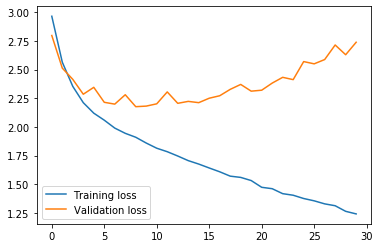

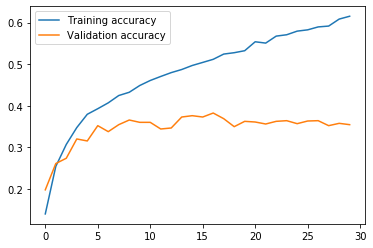

In [26]:
model1 = BaseNet()
hist = train_and_show(model1,simple_datagen,simple_datagen,batch_size = 32,epochs = 30)
showEvolution(hist)

Como podemos ver a partir de unas 10 épocas el valor de la función de pérdida comienza a subir, mientras que el valor de acierto del modelo se ha establecido en el intervalo $(0.37,0.4)$ desde aproximadamente unas 7 épocas, según la ejecución. Esto nos está indicando que el modelo ha aprendido lo suficiente y, como vemos, comienza a hacer *overfitting* en los datos, pues hay una gran diferencia entre el acierto en el conjunto de train y en el conjunto de validación cuando hay un aumento de épocas.

Recordemos que en cada ejecución los resultados pueden variar, pues los valores de los pesos se inicializan aleatoriamente cada vez.

# Mejora del modelo

Una vez que hemos implementado este modelo, vamos a pasar a realizar las mejoras sobre este. Se proponen una serie de mejoras que iremos tratando una por una y estudiando cómo varía el modelo. Comenzamos

## Normalización de los datos

Para la primera mejora, vamos a normalizar los datos para que tengan $\mu = 0$ y $\sigma^2 = 1$. Para ello tenemos la función que habíamos declarado anteriormente ***normalize_datagen***, que el objeto de la clase *ImageDataGenerator* genere los datos como nos interesa. En concreto, tendrá dos nuevos parámetros, que serán:
- *featurewise_center=True*, que nos hará que los datos tengan $\mu = 0$
- *featurewise_std_normalization=True* que hará que los datos tengan $\sigma^2 = 1$.

Con esto, solo tenemos que crear un nuevo modelo *BaseNet*, pero llamando esta vez en la función de ejecución a a la función ya mencionada. Veamos el resultado:

TEST SCORE =  0.3788


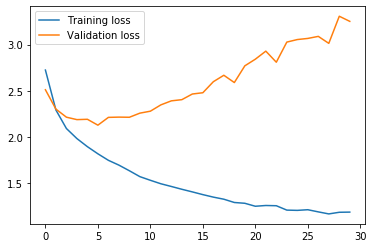

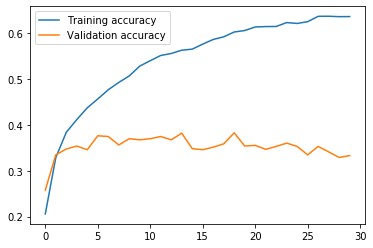

In [59]:
model2 = BaseNet()
#model2.summary()
hist2 = train_and_show(model2,normalize_datagen,batch_size = 32, epochs = 30)
showEvolution(hist2)


Podemos observar que, en caso de que haya mejora (debemos recordad que en este proceso influye la aleatoriedad, pues los pesos iniciales son aleatorios), la mejora que se obtiene es muy leve en el porcentaje de acierto del modelo cuando se ha utilizado este nuevo *datagen* que normaliza los datos.

Sin embargo, en modelos sucesivos, vamos a seguir utilizando la normalización del conjunto de datos pues es posible que al añadir más capas a nuestro modelo pueda sernos de utilidad para estas capas.

## Aumento de los datos

Una buena técnica para mejorar el entrenamiento de nuestra red es realizar **data augmentation**. Este consiste en modificar de diversas maneras las imágenes que tenemos de entrenamiento de forma que puedan obtener diferentes características y puedan aportar por ello más información a nuestro modelo. Algunas de las acciones más interesantes que podemos hacer para realizar este aumento de datos son:
- *Vertical/Horizontal Flip*, que volteará una imagen en el sentido que le podamos indicar
- *Zoom*, que hará zoom sobre una imagen según un rango que le indiquemos
- *Rotation*, que hará una rotación de nuestra imagen en el sentido indicado.

Hay que mencionar que este aumento de datos no se realiza siempre, sino que existe una probabilidad de que se le aplique a una imagen de forma aleatoria, de forma que no se realizará el aumento de datos que podamos indicar a todas las imágenes que tengamos para el entrenamiento.


Ahora, vamos a realizar el mismo procedimiento que en el caso anterior, pero vamos a añadir que el generador de datos haga además un **data_augmentation**. Comenzamos por uno sencillo. Para ello, además de los parámetros anteriores (que también estarán en nuestro objeto *datagen*, de cara a hacer comparativas entre los resultados obtenidos), se creará el objeto con los siguientes parámetros:
- *horizontal_flip = True*, que hará que algunas imágenes hagan *flip* aleatoriamente
- *zoom_range = 0.2*, que hará que se haga zoom aleatoriamente sobre algunas de las imágenes.

Veamos ahora los resultados de la ejecución.

TEST SCORE =  0.4528


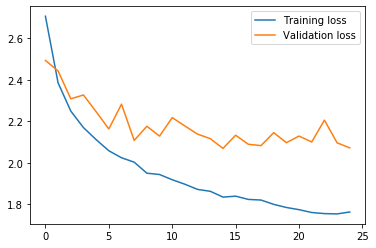

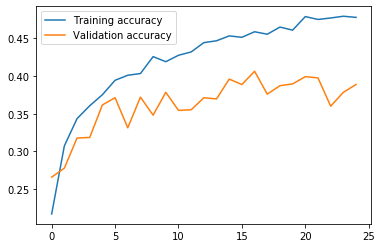

In [28]:
model3 = BaseNet()
#model3.summary()
hist3 = train_and_show(model3,data_augmentation_datagen,batch_size = 32,epochs = 25)
showEvolution(hist3)

Volvemos a obtener en este caso una mejora de $0.02$, lo cual es bastante  significativo , pues obtener una mejora del $0.01$ por ciento sabemos que ya es complicado. 

Sobre todo ,podemos observar en los histogramas que la precisión de acierto asciende más y se hace más cercana al *Training Accuracy* que en los casos anteriores, que es lo que nos interesa a la hora de clasificar. Este es un buen criterio para afirmar que el modelo es **mejor** cuando se normalizan los datos.

Ahora, sería interesante probar otros tipos de *data_augmentation*. Como se ha podido comprobar al principio en las funciones, temnemos otra llamada *data_augmentation_datagen2* que hará otro aumento de los datos diferente.  En concreto, los parámetros que tiene adicionales a la normalización son:
- *fill_mode = 'reflect'*, que se encarga de hacer que al aplicar los filtros, el borde que se utilice sea *BORDER_REFLECT*               
- *rotation_range = 45*, que hará que las imágenes puedan rotar un ángulo de 45 grados.
- *shear_range = 0.2*, que hará que se puedan hacer ciertos cortes en la imagen.



TEST SCORE =  0.4068


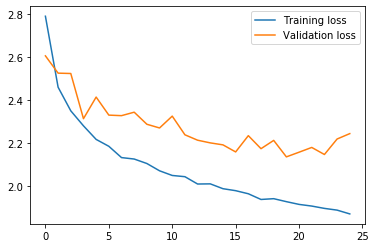

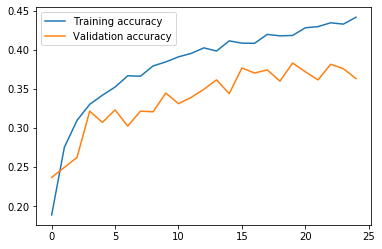

In [29]:
model_augmentation2 = BaseNet()
hist_augmentation2 = train_and_show(model_augmentation2,data_augmentation_datagen2,batch_size = 32,epochs = 25)
showEvolution(hist_augmentation2)

Los resultados que obtenemos son: tales

Ahora, vamos a hacer una prueba utilizando todos los parámetros que hemos usado anteriormente , pero a la vez. Veamos si tener una gran cantidad de formas de hacer *data_augmentation* nos proporciona un mejor resultado. Utilizamos la función *data_augmentation_all* que hemos definido.

TEST SCORE =  0.386


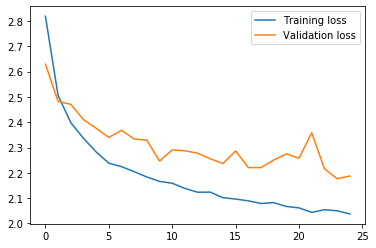

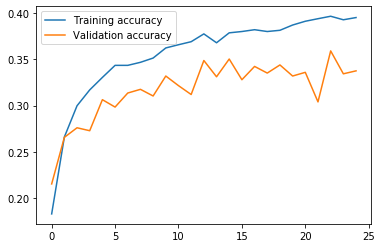

In [36]:
model_augmentation_all = BaseNet()
hist_augmentation_all = train_and_show(model_augmentation_all,train_data_gen = data_augmentation_all,batch_size = 32,epochs = 25)
showEvolution(hist_augmentation_all)

El resultado parece: tal

Vamos ahora a hacer la comparación entre los 3, para ver qué hemos obtenido:

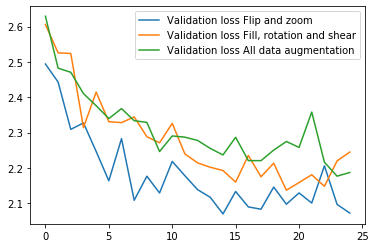

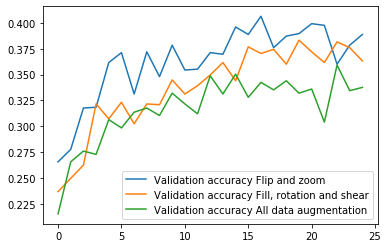

In [37]:
compareHists([hist3,hist_augmentation2,hist_augmentation_all],["Flip and zoom","Fill, rotation and shear","All data augmentation"])

Podemos ver que, al comparar los 3, obtenemos que el mejor *accuracy* en la validación lo obtenemos en el modelo de datos que hace solamente *Flip* y *Zoom* de las imágenes. Por debajo queda el que hace *Fill* y *Rotation*, y el último queda el que hace todas a la vez. Esto podría deberse a que hacer tantas modificaciones sobre las imágenes ralentice el aprendizaje del modelo pues le será más difícil reconocer características si las puede encontrar de diversas maneras.

Además, el modelo que usa más formas de *data augmentation* tiene también la función de pérdida más alta durante todo el tiempo, siendo el que utiliza *Flip and zoom* el que tiene la menor función de pérdida.

Es por esto que, a partir de ahora, consideraremos el primer *data_augmentation* como el mejor de los generadores de imágenes y es el que utilizaremos de ahora en adelante.



## Red más profunda

Vamos a tratar ahora de profundizar la red, añadiendo más capas a nuestro modelo inicial.

In [0]:
def deeper_basenet():
  model = Sequential()
  # First conv +  relu
  model.add(Conv2D(6,kernel_size = (5,5), activation='relu',input_shape=(32,32,3)))
  # Reduce size
  model.add(MaxPooling2D(pool_size = (2,2)))
  # Second Conv + relu
  model.add(Conv2D(16,kernel_size = (5,5), activation='relu'))
  # Third conv, bigger output size + relu
  model.add(Conv2D(32,kernel_size = (5,5),activation = 'relu'))
  # Reduce size
  model.add(MaxPooling2D(pool_size = (2,2)))
  # 4th conv, 3x3 this time
  model.add(Conv2D(64,kernel_size = (3,3),activation = 'relu'))
  # Flatten before FC
  model.add(Flatten())
  # FC. add Relu output size = 100
  model.add(Dense(100, activation = 'relu'))
  # FC and relu, smaller output size = 50
  model.add(Dense(50,activation = 'relu'))
  # FC and softmax
  model.add(Dense(25,activation = 'softmax'))

  return model
  

Una vez definida, vemos que hemos añadido las siguientes capas:
- *Conv2D* después de las anteriores, pero con un *outputSize* mayor.
- *Conv2D* antes de hacer *Flatten*, pero con un tamaño de kérnel menor al de las anteriores
- *Dense*, una nueva capa FC pero con un tamaño de salida mayor

Con esto, tratamos de ver si añadiendo más capas de convolución con parámetros parecidos a los que ya teníamos anteriormente, obtenemos una mejora en los resultados.

A partir de ahora, utilizaremos el objeto de *ImageDataGenerator* que nos da mejores resultados hasta el momento, es decir, el que realiza **dataAugmentation**.

Vamos ahora a ver los resultados. Ejecutamos dos veces, uno con 15 épocas y otro con 40, para ver cómo varía según las épocas. Las dos primeras imágenes se corresponderán con las $15$ épocas y las dos segundas con las $40$ épocas.

TEST SCORE =  0.4012


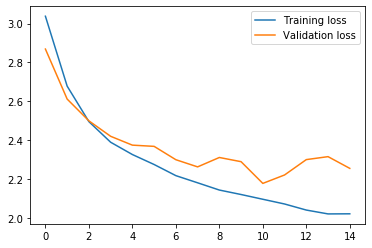

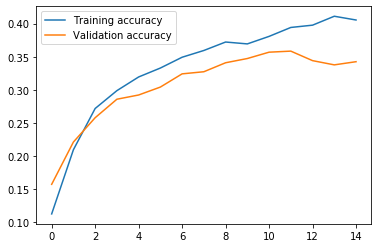

TEST SCORE =  0.4224


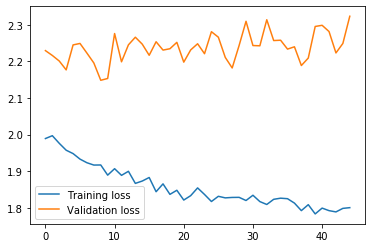

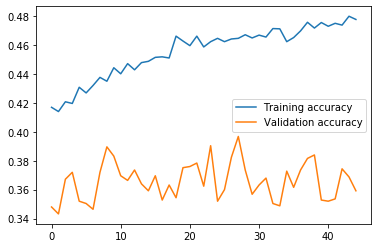

In [61]:
model4 = deeper_basenet()
#model4.summary()
hist4 = train_and_show(model4,data_augmentation_datagen,batch_size = 32,epochs = 15)
showEvolution(hist4)
hist5 = train_and_show(model4,data_augmentation_datagen,batch_size = 32, epochs = 45)

showEvolution(hist5)

Podemos observar como hay un empeoramiento de los resultados respecto a nuestro mejor modelo (que conseguía $0.45$ de acierto en *test*), a pesar incluso de establecer un número de épocas bastante mayor. Esto nos indica que añadir más capas no tiene por qué mejorar los resultados. Tampoco aunque aumentemos el número de épocas esto tiene por qué mejorar.

 Además, podemos ver que estamos tratando de buscar casi el doble de parámetros que en los anteriores modelos.




### Uso de Kernels más pequeños

 Vamos a probar ahora a tomar tamaños de kernel siempre de $3\times 3$, y veamos cómo afecta esto a los resultados. Llamaremos al nuevo modelo **small_kernel_basenet**, y será igual que el anterior salvo que:
- Todas las *Conv2D* tendrán $kernel\_size = (3,3)$
- Quitaremos la capa FC que tenía como *OutputSize = 50*.

In [0]:

def small_kernel_basenet():
  model = Sequential()
  # First conv +  relu
  model.add(Conv2D(6,kernel_size = (3,3), activation='relu',input_shape=(32,32,3)))
  # Reduce size
  model.add(MaxPooling2D(pool_size = (2,2)))
  # Second Conv + relu
  model.add(Conv2D(16,kernel_size = (3,3), activation='relu'))
  # Third conv, bigger output size + relu
  model.add(Conv2D(32,kernel_size = (3,3),activation = 'relu'))
  # Reduce size
  model.add(MaxPooling2D(pool_size = (2,2)))
  # 4th conv, 3x3 this time
  model.add(Conv2D(64,kernel_size = (3,3),activation = 'relu'))
  # Flatten before FC
  model.add(Flatten())
  # FC. add Relu output size = 100
  model.add(Dense(100, activation = 'relu'))
  # FC and softmax
  model.add(Dense(25,activation = 'softmax'))

  return model

TEST SCORE =  0.478


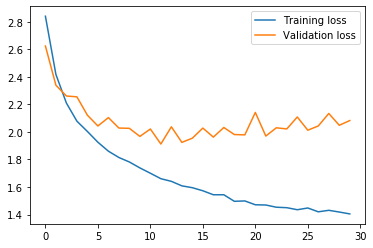

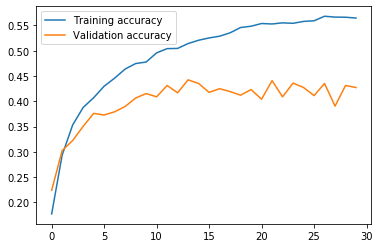

In [41]:
model5 = small_kernel_basenet()
#model5.summary()
hist6 = train_and_show(model5,data_augmentation_datagen,batch_size = 32,epochs = 30)
showEvolution(hist6)

En este caso, se consigue una pequeña mejora, vemos como ambas gráficas se acercan más a las gráficas de *entrenamiento*, lo cual quiere decir que los pesos que está obteniendo nuestra red neuronal en el entrenamiento son suficientemente buenos como para obtener un acierto parecido en el entrenamiento y en la validación después.

Esto quiere decir que nuestro modelo está entrenando lo suficiente (pues vemos que el acierto en validación llega a un punto en el que no asciende con notoriedad, lo cual nos indica que hemos aprendido más o menos lo que podíamos en general), y que , como nos estamos acercando con el acierto en validación al acierto en *train*, estamos aprendiendo buenas características que nos ayudan a obtener el mayor porcentaje de acierto posible en este caso.

## Batch Normalization
**Batch Normalization** es una técnica para mejorar el funcionamiento, velocidad y estabilidad de nuestra red neuronal convolucional. Consiste en normalizar según *batches*, es decir, tomar un *batch* de imágenes que se tomará del tamaño *batch_size* que hayamos utilizado, y hacer una normalización usando solo esas imágenes.

Vamos a tratar de añadir a nuestro modelo algunas capas de *BatchNormalization* para reducir el *overfitting* de nuestro modelo. 


Lo haremos sobre el último modelo que hemos utilizado, que es el que parece que nos ha dado los mejores resultados aunque tenga un número de parámetros a entrenar bastante mayor que el resto de modelos.

Vamos a añadir estas capas de *BatchNormalization* antes y después de las capas convolucionales, y compararemos los resultados obtenidos.

### Antes de *relu*

Vamos a definir primero un modelo en el que el *Batch Normalization* se hará después de las activaciones *relu*:

In [0]:
def bn_after_relu_basenet():
  model = Sequential()
  # First conv +  relu
  model.add(Conv2D(6,kernel_size = (3,3), activation='relu',input_shape=(32,32,3)))
  # Batch Normalization
  model.add(BatchNormalization())
  # Reduce size
  model.add(MaxPooling2D(pool_size = (2,2)))
  # Second Conv + relu
  model.add(Conv2D(16,kernel_size = (3,3), activation='relu'))
  # Another Batch Normalization
  model.add(BatchNormalization())
  # Third conv, bigger output size + relu
  model.add(Conv2D(32,kernel_size = (3,3),activation = 'relu'))
  # Reduce size
  model.add(MaxPooling2D(pool_size = (2,2)))
  # 4th conv, 3x3 this time
  model.add(Conv2D(64,kernel_size = (3,3),activation = 'relu'))
  # Flatten before FC
  model.add(Flatten())
  # FC. add Relu output size = 100
  model.add(Dense(100, activation = 'relu'))
  # FC and softmax
  model.add(Dense(25,activation = 'softmax'))

  return model

TEST SCORE =  0.5064


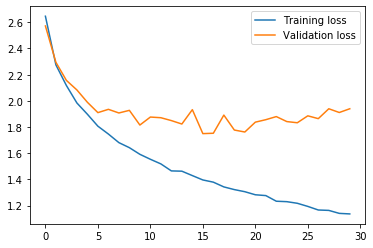

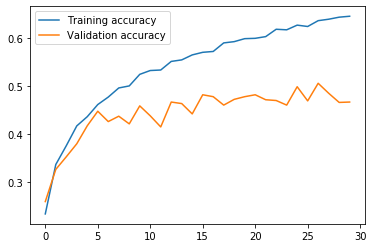

In [44]:
model6 = bn_after_relu_basenet()
#model6.summary()
hist7 = train_and_show(model6,data_augmentation_datagen,batch_size = 32,epochs = 30)
showEvolution(hist7)

El cambio es bastante significativo. Podemos ver en la gráfica que en estas 30 épocas, la función de *score* no para de aumentar ni si quiera en el conjunto de entrenamiento. Se obtiene una clasificación que es mejor en más 10 puntos porcentuales con respecto al modelo inicial, lo cual es un cambio sigficativo, llegando casi a quedarse en $0.5$ de aciertos en el conjunto de test.

Podemos también apreciar que nos aparecen *44 non trainable parameters* (parámetros no entrenables), esto nos indica que tenemos parámetros que no se pueden optimizar con los datos que tenemos. Estos probablemente hayan aparecido de haber introducido capas como *Batch Normalization* o *Relu*, que son capas que no se entrenan.

Este es hasta ahora el mejor modelo obtenido , gracias a su buen *test_score* y a que su proximidad de las gráficas de validación y las de train es mayor que en el resto de casos.

### Después de Relu

Ahora, vamos a ver cómo se comporta el modelo si hacemos esta *Batch Normalization* después de hacer la activación *relu*. A priori, el resultado podría variar, pues al hacer normalizaciones en los batch, podría haber alguna modificación en los valores negativos de este y cambiar algunos valores obtenidos en la aplicación de *relu*. 

Definamos el modelo que tenga ahora las activaciones *relu* después de las normalizaciones en Batch:





In [0]:
def bn_before_relu_basenet():
  model = Sequential()
  # First conv +  relu
  model.add(Conv2D(6,kernel_size = (3,3),input_shape=(32,32,3)))
  # Batch Normalization
  model.add(BatchNormalization())
  # Now ReLu
  model.add(Activation('relu'))
  # Reduce size
  model.add(MaxPooling2D(pool_size = (2,2)))
  # Second Conv + relu
  model.add(Conv2D(16,kernel_size = (3,3)))
  # Another Batch Normalization
  model.add(BatchNormalization())
  #Relu after Batch
  model.add(Activation('relu'))
  # Third conv, bigger output size + relu
  model.add(Conv2D(32,kernel_size = (3,3),activation = 'relu'))
  # Reduce size
  model.add(MaxPooling2D(pool_size = (2,2)))
  # 4th conv, 3x3 this time
  model.add(Conv2D(64,kernel_size = (3,3),activation = 'relu'))
  # Flatten before FC
  model.add(Flatten())
  # FC. add Relu output size = 100
  model.add(Dense(100, activation = 'relu'))
  # FC and softmax
  model.add(Dense(25,activation = 'softmax'))

  return model

TEST SCORE =  0.5056


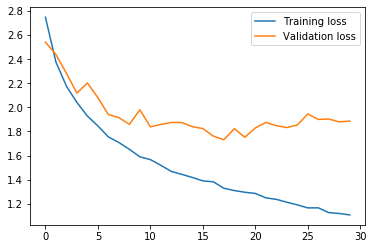

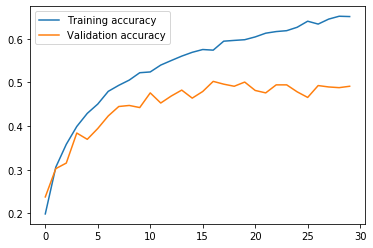

In [46]:
model7 = bn_before_relu_basenet()
#model7.summary()
hist8 = train_and_show(model7,data_augmentation_datagen,batch_size = 32,epochs = 30)
showEvolution(hist8)

Vamos a comparar ambas gráficas y ver qué resultados podemos obtener:

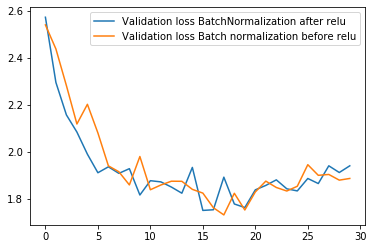

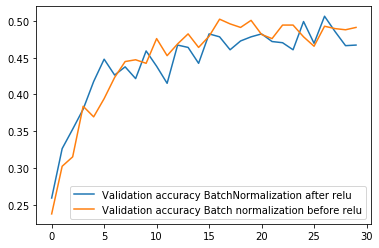

In [47]:
compareHists([hist7,hist8],["BatchNormalization after relu","Batch normalization before relu"])

Podemos observar como el resultado que se obtiene al evaluar en el conjunto de test no difiere mucho en ambos modelos. Sin embargo, si estudiamos las gráficas, vemos que:
- La función de pérdida es prácticamente siempre inferior cuando *Batch Normalization* se realiza **después** de *relu*.
- El acierto es siempre mayor en los conjuntos de validación durante el entrenamiento cuando *Batch Normalization* se realiza **después** de *relu*.

A pesar de no haber mucha diferencia, hemos obtenido que si hacemos la normalización **después** de hacer la activación *relu*, tanto la función de pérdida es un poco menor que haciéndo la normalización antes, como el acierto es algo mayor, así que podríamos decir que obtenemos mejores resultados si hacemos *Batch Normalization* **después** de hacer *relu*. Es por ello que a partir de ahora tomaremos en los sucesivos modelos como base el modelo *bn_after_relu_basenet*


### Batch Normalization en capas FC

Vamos a hacer ahora una nueva prueba, trataremos de hacer *Batch Normalization* , además de después de algunas *relu*, después de alguna capa *Dense* y veamos si esto mejora sustancialmente o empeora los resultados.

Definamos primero el modelo,partiendo del modelo que ya hemos mencionado.

In [0]:
def bn_fc_basenet():
  model = Sequential()
  # First conv +  relu
  model.add(Conv2D(6,kernel_size = (3,3), activation='relu',input_shape=(32,32,3)))
  # Batch Normalization
  model.add(BatchNormalization())
  # Reduce size
  model.add(MaxPooling2D(pool_size = (2,2)))
  # Second Conv + relu
  model.add(Conv2D(16,kernel_size = (3,3), activation='relu'))
  # Another Batch Normalization
  model.add(BatchNormalization())
  # Third conv, bigger output size + relu
  model.add(Conv2D(32,kernel_size = (3,3),activation = 'relu'))
  # Reduce size
  model.add(MaxPooling2D(pool_size = (2,2)))
  # 4th conv, 3x3 this time
  model.add(Conv2D(64,kernel_size = (3,3),activation = 'relu'))
  # Flatten before FC
  model.add(Flatten())
  # FC. add Relu output size = 100
  model.add(Dense(100, activation = 'relu'))
  # Batch normalization in FC
  model.add(BatchNormalization())
  # FC and softmax
  model.add(Dense(25,activation = 'softmax'))

  return model

Ahora, entrenamos este modelo y lo comparamos directamente con el resultado del mismo modelo pero sin añadir la normalización en la capa FC.

TEST SCORE =  0.52


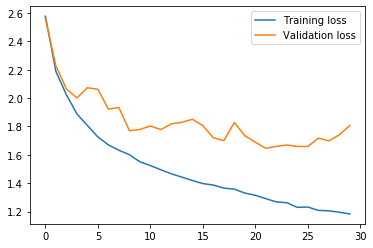

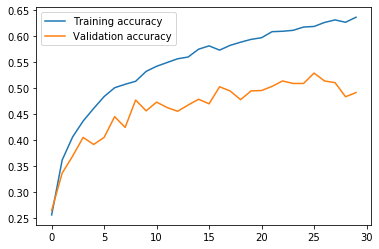

In [49]:
model8 = bn_fc_basenet()
hist9 = train_and_show(model8,data_augmentation_datagen,batch_size = 32,epochs = 30)
showEvolution(hist9)

Los comparamos en la misma gráfica

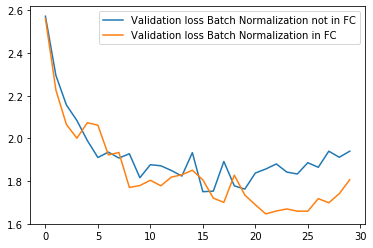

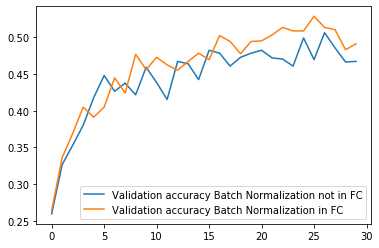

In [50]:
compareHists([hist7,hist9],["Batch Normalization not in FC","Batch Normalization in FC"])

Los resultados nos muestran lo siguiente:

- Aunque en el comienzo sea mayor, la función de pérdida es generalmente **menor** cuando tenemos *Batch Normalization* en las capas FC que cuando no la tenemos.
- *Batch Normalization* en las capas FC nos proporciona un mayor acierto en el conjunto de validación
- El *test score* final es muy parecido entre ambas. En la última ejecución hecha, el mayor ha sido en la que tiene *BN* en la capa *FC*, por lo que de ahora en adelante usaremos este modelo como base.

Con estos resultados, podemos enunciar que hacer *Batch Normalization* en las últimas capas nos está ayudando a obtener un entrenamiento más general que no utilizarlo en este tipo de capas, por lo cual, utilizarlo en ellas supone una **mejora** respecto a nuestro modelo.

## Early Stopping

Una buena opción en nuestro entrenamiento puede ser hacer una parada del entrenamiento si el modelo no consigue mejorar tras pasar un número de épocas que nos interese, para que no se alargue en tiempo de ejecución innecesariamente. Esto es justamente el *early stopping*.

 Vamos a utilizar ahora el parámetro que hemos definido en nuestra función de entrenamiento. *Early Stopping* nos ayudará a que el entrenamiento termine de forma anticipada y evitará así el posible *overfitting*. Además, al terminar de forma anticipada el entrenamiento, habremos conseguido más rapidez en el mismo.

Comentar primero que un **callback** es , según la documentación de *Keras*, un conjunto de funciones que se aplican en ciertos momentos del proceso de entrenamiento. Una de las funciones que se le puede aplicar es *Early Stopping*.

 Si le indicamos a nuestra función que queremos *Early Stopping*, se le indicará a *fit_generator* que el conjunto de *callbacks* esté formado por la función *EarlyStopping*. Esta función tiene varios parámetros, pero los que tendremos en cuenta serán:
 - *monitor*, que es el parámetro que queremos ver si está cambiando durante las épocas
 - *patience*, que es el número de épocas que queremos esperar sin que se modifique para parar el entrenamiento


 En nuestro caso, creo que esto no será muy relevante pues el número de épocas que estamos usando en el entrenamiento es muy pequeño (recordemos que es solamente 30). Así que, para que pudiera tener algo de impacto en el entrenamiento, vamos a establecer que nuestro algoritmo tenga "poca paciencia", y haga *EarlyStopping* si no mejora en **3** épocas. 

 Vamos a ver cómo actúa el mejor modelo obtenido hasta ahora si activamos *Early Stopping*.

TEST SCORE =  0.5244


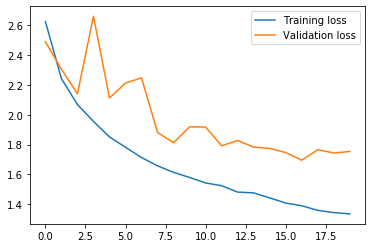

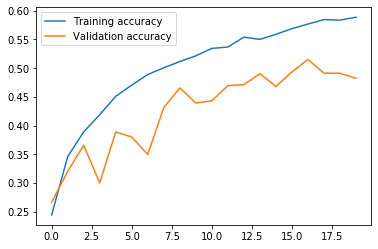

In [58]:
model8 = bn_fc_basenet()
hist9 = train_and_show(model8,data_augmentation_datagen,early_stopping=True,batch_size = 32,epochs = 30)
showEvolution(hist9)

Vemos como hemos obtenido un *early stopping* a las 10 épocas, porque no hemos conseguido entre la época 9 y 10 que la función de pérdida disminuya en el conjunto de validación, como queríamos ver. A costa de esto, hemos obtenido una pequeña pérdida en el *test score* final, descendiendo en dos puntos porcentuales. 

Es posible que el número de épocas de *patience* que estamos estableciendo no sea suficiente. Sin embargo,

 

# La verdadera mejora : Dropout

Tras este proceso de pruebas y mejoras, vamos a utilizar ahora la capa que nos va a dar un salto mayor en el acierto en el conjunto de test. Se trata de las capas **Dropout**. 

Las capas *Dropout* harán que las neuronas de nuestro modelo tengan una probabilidad de dejar de ser entrenadas. En concreto, dada una probabilidad *rate* que pasaremos como parámetro,lo que hará según la documentación de *keras* es poner los inputs para esa neurona a 0, lo cual nos ayudará a prevenir el overfitting.

Dejar de entrenar ciertas neuronas prevendrá la creación de inter-dependencias entre las neuronas, lo que nos ayudará a obtener un modelo más robusto en cuanto a dependencias entre nodos.

Vamos a definir un modelo basándonos en nuestro mejor modelo anterior. Haibing y Xiaodong en [@Haibing-Xiaodong] mencionan que aunque al principio se utilizaban solo *dropouts* en capas que no estuvieran *FC*, finalmente se encontró que usarlos también en capas *FC* reduce el error en el *test*, así que en nuestro modelo lo utilizaremos en ambas partes.

[@Haibing-Xiaodong]: https://arxiv.org/pdf/1512.00242.pdf "Towards Dropout Training for Convolutional Neural Networks"

Pasamos a definir el modelo.



In [0]:
def dropout_basenet():
  model = Sequential()
  # First conv +  relu
  model.add(Conv2D(6,kernel_size = (3,3), activation='relu',input_shape=(32,32,3)))
  # Batch Normalization
  model.add(BatchNormalization())
  # Reduce size
  model.add(MaxPooling2D(pool_size = (2,2)))
  # Dropout
  model.add(Dropout(0.25))
  # Second Conv + relu
  model.add(Conv2D(16,kernel_size = (3,3), activation='relu'))
  # Another Batch Normalization
  model.add(BatchNormalization())
  # Third conv, bigger output size + relu
  model.add(Conv2D(32,kernel_size = (3,3),activation = 'relu'))
  # Reduce size
  model.add(MaxPooling2D(pool_size = (2,2)))
  # Dropout
  model.add(Dropout(0.25))
  # 4th conv, 3x3 this time
  model.add(Conv2D(64,kernel_size = (3,3),activation = 'relu'))
  # Flatten before FC
  model.add(Flatten())
  # FC. add Relu output size = 100
  model.add(Dense(100, activation = 'relu'))
  # Batch normalization in FC
  model.add(BatchNormalization())
  # Dropout 
  model.add(Dropout(0.5))
  # FC and softmax
  model.add(Dense(25,activation = 'softmax'))

  return model

Hemos añadido:
- *Dropout* con $rate = 0.25$ después del primer *MaxPooling*
- *Dropout* con $rate = 0.25$ después del segundo (y último) *MaxPooling)
- *Dropout* con $rate = 0.5$ antes de la última capa *Dense+Softmax*

Veamos el comportamiento del mismo.

TEST SCORE =  0.4936


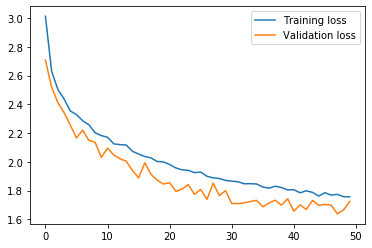

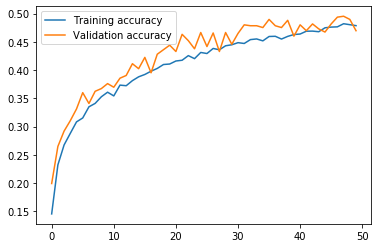

In [53]:
model9 = dropout_basenet()
hist10 = train_and_show(model9,data_augmentation_datagen,batch_size = 32,epochs = 50)
showEvolution(hist10)

Sorprendentemente, tenemos que la gráfica de validación está por debajo en la función de pérdida. Esto es una noticia bastante buena, aunque difícil de comprender. Significa que nuestro modelo está generalizando mejor incluso de lo que puede conseguir solo con el *train dataset*.

Se podría pensar que los ratios de *Dropout* que se están dando son demasiado altos. Sin embargo, un ratio más pequeño haría que prácticamente no se notara respecto a otras ejecuciones que no tuvieran *Dropout*. Vamos a hacer la prueba, cambiaremos el *rate* de los  tres anteriores por $0.1$ en el próximo modelo, lo ejecutaremos y luego los compararemos.

In [0]:
def low_dropout_basenet():
  model = Sequential()
  # First conv +  relu
  model.add(Conv2D(6,kernel_size = (3,3), activation='relu',input_shape=(32,32,3)))
  # Batch Normalization
  model.add(BatchNormalization())
  # Reduce size
  model.add(MaxPooling2D(pool_size = (2,2)))
  # Dropout
  model.add(Dropout(0.1))
  # Second Conv + relu
  model.add(Conv2D(16,kernel_size = (3,3), activation='relu'))
  # Another Batch Normalization
  model.add(BatchNormalization())
  # Third conv, bigger output size + relu
  model.add(Conv2D(32,kernel_size = (3,3),activation = 'relu'))
  # Reduce size
  model.add(MaxPooling2D(pool_size = (2,2)))
  # Dropout
  model.add(Dropout(0.1))
  # 4th conv, 3x3 this time
  model.add(Conv2D(64,kernel_size = (3,3),activation = 'relu'))
  # Flatten before FC
  model.add(Flatten())
  # FC. add Relu output size = 100
  model.add(Dense(100, activation = 'relu'))
  # Batch normalization in FC
  model.add(BatchNormalization())
  # Dropout 
  model.add(Dropout(0.1))
  # FC and softmax
  model.add(Dense(25,activation = 'softmax'))

  return model

TEST SCORE =  0.58


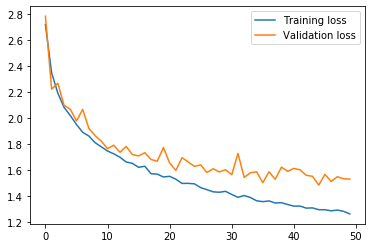

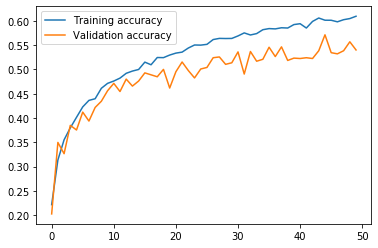

In [55]:
model10 = low_dropout_basenet()
hist11 = train_and_show(model10,data_augmentation_datagen,batch_size = 32,epochs = 50)
showEvolution(hist11)

Y, con esto, acabamos de obtener el mejor *test_score* hasta ahora. Vemos como, en comparación con la anterior ejecución con *Dropout*, las gráficas de validación quedan ahora (como es de esperar), con peores resultados que las gráficas de *training*.

Sin embargo, es un muy buen resultado pues vemos que el *accuracy* de validación queda muy cerca de la gráfica del *accuracy* de *training*.

Veamos la comparación entre ambas gráficas por ver quién podríamos decir que es "mejor".

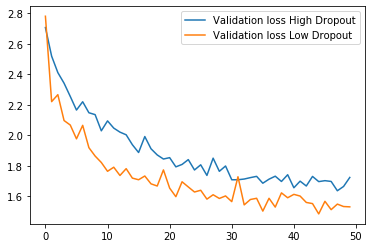

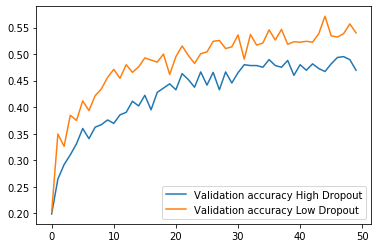

In [56]:
compareHists([hist10,hist11],["High Dropout","Low Dropout"])

Se ve claramente como , teniendo un *Dropout* bajo, tenemos una gráfica de pérdida **mayor** (lo cual es peor), y una gráfica de **accuracy** mayor, por lo que podríamos decir que *en general*, es mejor utilizar unos niveles más altos de *Dropout*.